In [1]:
import pandas as pd
from fcmeans import FCM
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull
from scipy import interpolate

In [24]:
"""
Fuzzy C Means Clustering on Multi-dimensional Features

Algorithm:

Before using FCM algorithm, we transform the feature space into a 2-dimensional space by utilizing the t stochastic neighbor embedding (t-SNE) algorithm.

"""

class FCM_MD:
    def __init__(self, df):
        self.df = df
    
    def retrieve_components(self):
        # Retrieve numeric features
        self.df = self.df.select_dtypes('number')

        # Retrieve features
        features = self.df.values

        # Create tSNE Components
        tsne = TSNE(n_components=2, verbose=1, random_state=123)

        return tsne.fit_transform(features)
    
    def fcm(self, num_clusters: int, md: bool):
        # Instantiate FCM Algorithm
        self.model = FCM(n_clusters=num_clusters)

        # Instantiate Lower Dimensional DataFrame
        result_df = self.df

        if md == True: 
            z = self.retrieve_components()
            result_df = pd.DataFrame()
            result_df['comp-1'] = z[:,0]
            result_df['comp-2']= z[:,1]

        # Use Features from t-SNE Components
        features = result_df.values

        # Fit FCM Model
        self.model.fit(features)

        # Centers, Labels
        self.centers = self.model.centers
        self.labels = self.model.predict(features)

        # Look at the the two artifacts as a DataFrame
        result_df['cluster_labels'] = self.labels

        return result_df



In [25]:
from warnings import filterwarnings

filterwarnings('ignore')

In [26]:
# Elbow Criterion
from os import getcwd, chdir

# Change Path to Raw folder
chdir("../../data/raw/")

# Read the DataFrame
df = pd.read_csv("Iris.csv")  #("OCC_testrun.csv")

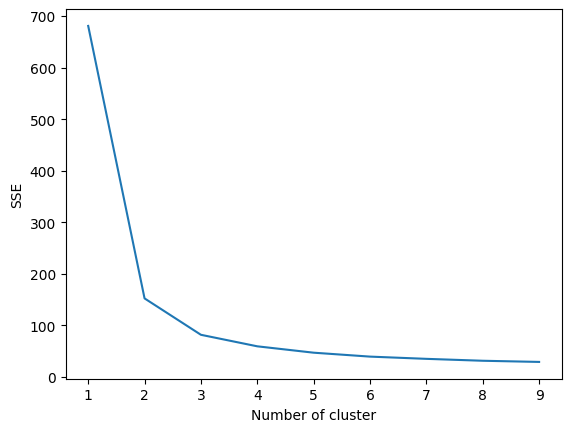

In [27]:
#Features are everything except Id and Species
data = df.drop(['Id', 'Species'], axis = 1)

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [29]:
# Instnatiate the FCM_MD Class
fcm_md = FCM_MD(data)

# Create the FCM Results with 3 clusters
results = fcm_md.fcm(num_clusters=3, md = False)

# View Results DataFrame
print(results.head())

# Viewing the centers
print(fcm_md.centers.shape)

cen_x = [i[0] for i in fcm_md.centers]
cen_y = [i[1] for i in fcm_md.centers]

print(cen_x)
print(cen_y)


   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  clusters  \
0            5.1           3.5            1.4           0.2         4   
1            4.9           3.0            1.4           0.2         1   
2            4.7           3.2            1.3           0.2         1   
3            4.6           3.1            1.5           0.2         1   
4            5.0           3.6            1.4           0.2         4   

   cluster_labels  
0               0  
1               0  
2               0  
3               0  
4               0  
(3, 5)
[5.0777581071302915, 6.803806314245672, 5.980876088941824]
[3.426362747319139, 3.075157056467269, 2.809864193869052]


In [30]:
results

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,clusters,cluster_labels
0,5.1,3.5,1.4,0.2,4,0
1,4.9,3.0,1.4,0.2,1,0
2,4.7,3.2,1.3,0.2,1,0
3,4.6,3.1,1.5,0.2,1,0
4,5.0,3.6,1.4,0.2,4,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,8,1
146,6.3,2.5,5.0,1.9,5,1
147,6.5,3.0,5.2,2.0,0,2
148,6.2,3.4,5.4,2.3,8,1


In [31]:
def prepare_visual_data(df, fcm_md):
    # Want to centers x and y
    centers = fcm_md.centers

    cen_x = [i[0] for i in centers]
    cen_y = [i[1] for i in centers]

    df['cen_x'] = df['cluster_labels'].map({i: cen_x[i] for i in df['cluster_labels'].unique()})
    df['cen_y'] = df['cluster_labels'].map({i: cen_y[i] for i in df['cluster_labels'].unique()})

    # Define colors
    colors = ['#DF2020', '#81DF20', '#2095DF']

    # Create color scheme
    df['c'] = df['cluster_labels'].map({i : colors[i] for i in range(len(colors))})

    return df, colors, cen_x, cen_y

result_df, colors, cen_x, cen_y = prepare_visual_data(results, fcm_md)

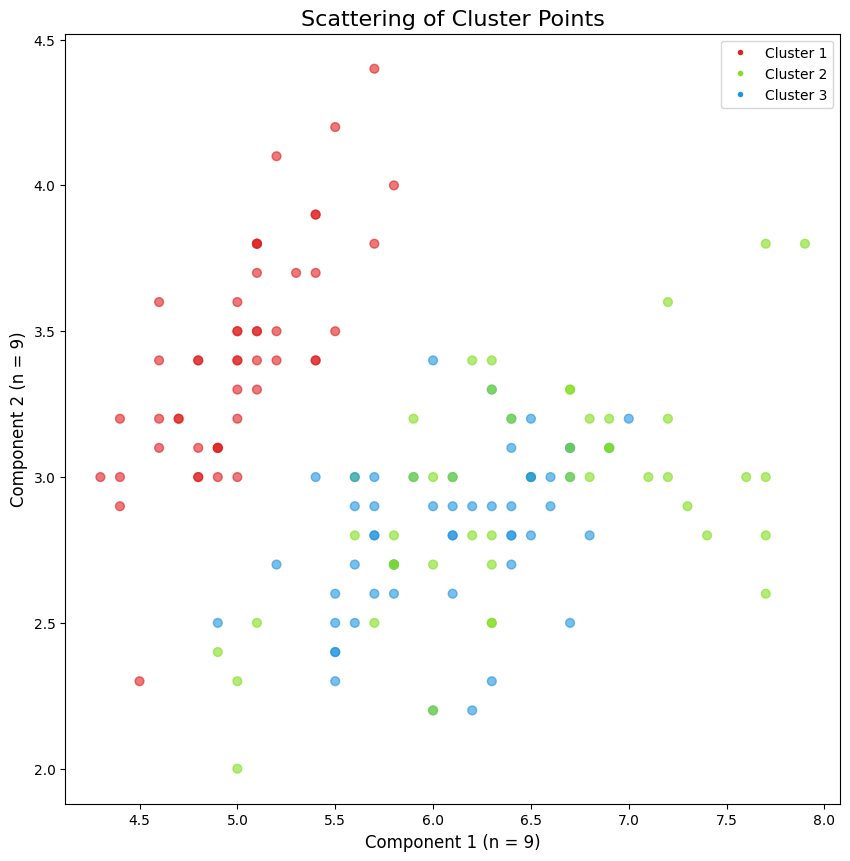

In [33]:
# Scatter Plot
def create_scatter(df, col1, col2, colors):
    plt.figure(figsize=(10,10))
    plt.scatter(df[col1], df[col2], c=df['c'], alpha=0.6, s=40)
    plt.title("Scattering of Cluster Points", size=16)
    plt.xlabel(f'Component 1 (n = {fcm_md.df.shape[1]})', size=12)
    plt.ylabel(f'Component 2 (n = {fcm_md.df.shape[1]})', size=12)
    label_handles = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}',
                    markerfacecolor=mcolor, markersize=5) for i,
                    mcolor in enumerate(colors)]
    plt.legend(handles=label_handles, loc='upper right')
    plt.show()


create_scatter(result_df, 'SepalLengthCm', 'SepalWidthCm', colors)

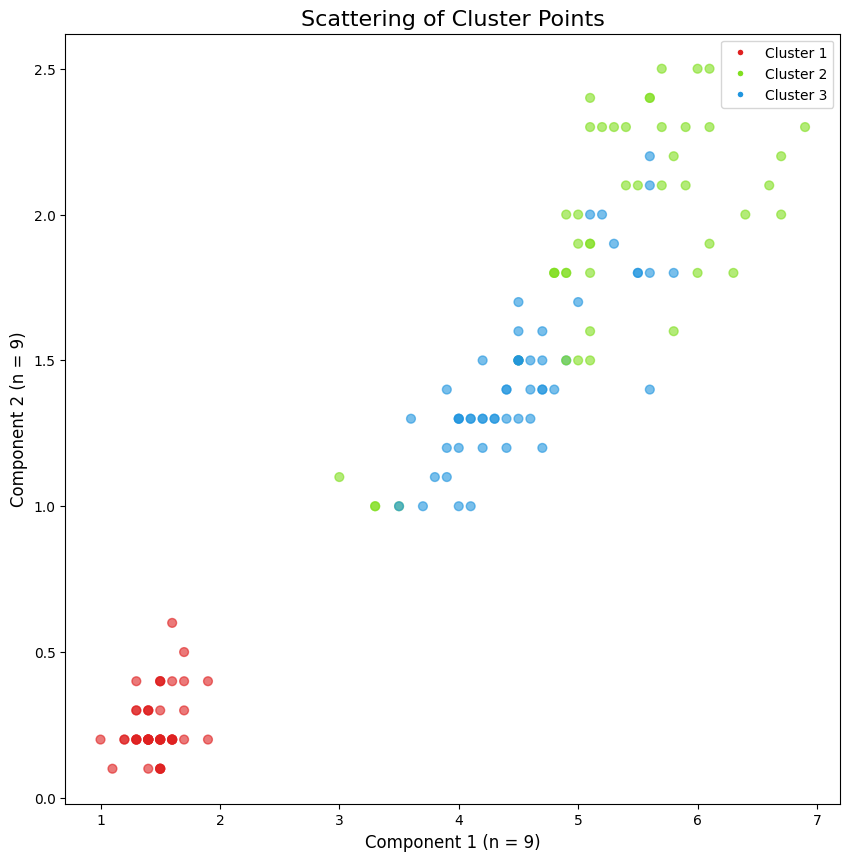

In [34]:
create_scatter(result_df, 'PetalLengthCm', 'PetalWidthCm', colors)

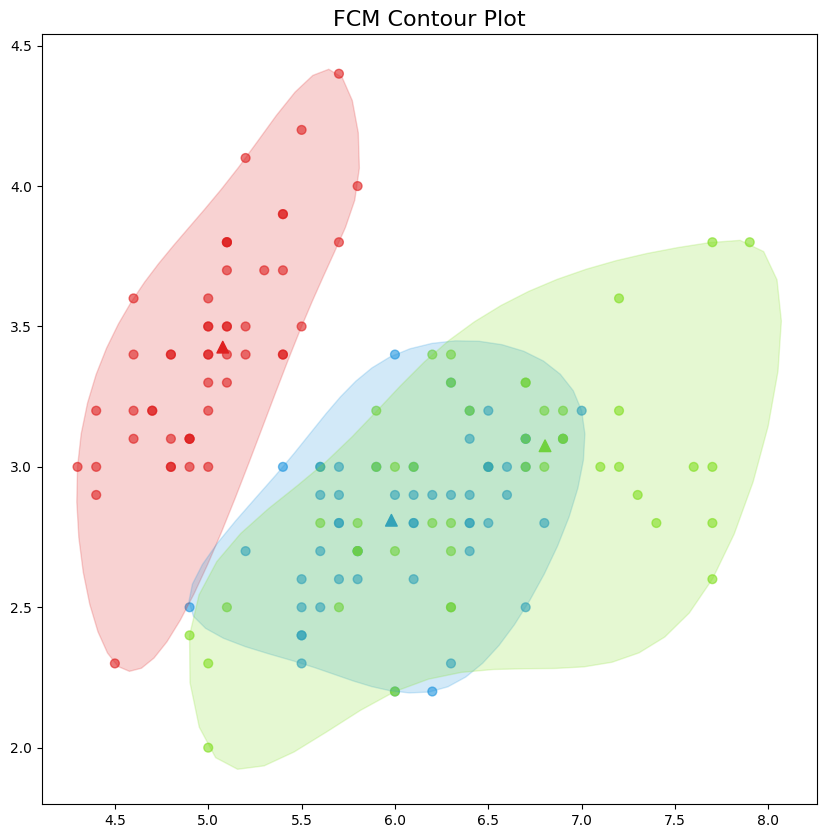

In [36]:
# Contour Plot
def create_contour_plot(df, colors, col1, col2, cen_x, cen_y):
    plt.figure(figsize=(10,10))

    plt.title("FCM Contour Plot", size=16)
    
    # Scatter components
    plt.scatter(df[col1], df[col2], c=df.c, alpha=0.6, s=40)

    # Scattering the centers for both components
    plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)

    # Go through each cluster and build convex hulls
    for i in df['cluster_labels'].unique():
        # Get the Convex Hull
        points = df[df['cluster_labels'] == i][[col1, col2]].values
        hull = ConvexHull(points)

        x_hull = np.append(points[hull.vertices, 0],
                            points[hull.vertices, 0][0])
        
        y_hull = np.append(points[hull.vertices, 1],
                            points[hull.vertices, 1][0])
        
        # Interpolation
        dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
        dist_along = np.concatenate(([0], dist.cumsum()))
        spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0, per=1)
        interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
        interp_x, interp_y = interpolate.splev(interp_d, spline)

        # Plot Shape
        plt.fill(interp_x, interp_y, '--', c=colors[i], alpha=0.2)


    # plt.xlim(0, 200)
    # plt.ylim(0, 200)
    plt.show()

create_contour_plot(result_df, colors, 'SepalLengthCm', 'SepalWidthCm', cen_x, cen_y)

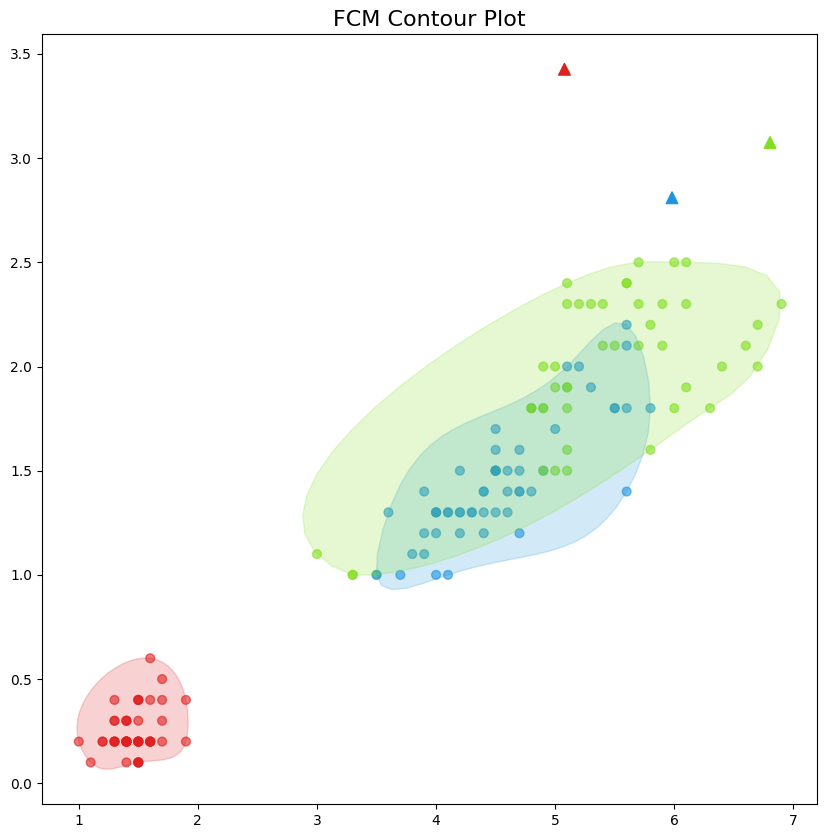

In [37]:
create_contour_plot(result_df, colors, 'PetalLengthCm', 'PetalWidthCm', cen_x, cen_y)